In [1]:
from houzz.impala.query import impala_query
from houzz.hive import hive_query

import pandas as pd
import numpy as np
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import display, HTML
from IPython.display import Image
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import urllib2
import webbrowser
import csv

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

def run(q):
    h, d = impala_query(q)
    return pd.DataFrame(d, columns=h)

def run_hive(q):
    h, d = hive_query(q)
    return pd.DataFrame(d, columns=h)

def plot_line(input_df, cols, xx, title):
    plt.figure()
    plot_df = input_df.sort_values(by=[xx]).set_index([xx]).ix[:, cols]
    plot_df.plot(kind = 'line', figsize=(15,3), title=title)
    plt.show()

def add_pct(input_df, col):
    total = input_df[col].sum()
    input_df['percent_%'] = input_df[col] * 100.0 / total
    return input_df

def color_negative_red(row):
    """ Color code lift or drop in test result dataframe if it is significant """
    return ['color: green' if row['Lift'] > 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else 'color: red' if row['Lift'] < 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else '' for v in row]

# plots day_by_day metrics
def day_by_day(input_df, col_list, control, treatment):
    df_ctl = input_df[input_df['test_variant'] == control].set_index('dt')
    df_trt = input_df[input_df['test_variant'] == treatment].set_index('dt')
    df2 = df_ctl.join(df_trt, lsuffix='_control', rsuffix='_treatment', on='dt').reset_index()
    display(df2.head())
    for col in col_list:
        plot_line(df2, cols=[col+'_control', col+'_treatment'], xx='dt', title=col)
        
# outputs t-test results on numerical values
def calculate(input_df, col_list, control, treatment):
    slices = 'All'
    slice_value = 'All'
    columns = ['Metric', 'Treatment Size', 'Treatment Total', 'Treatment Mean',
               'Control Size', 'Control Total', 'Control Mean', 'P-value']

    ctl_size = input_df[(input_df['test_variant'] == control)] ['visitors'].sum()
    trt_size = input_df[(input_df['test_variant'] == treatment)] ['visitors'].sum()
    total_sample_size = ctl_size + trt_size

    df_egg_overall = pd.DataFrame(columns=columns)
    for metric in col_list:
        ctl = input_df[(input_df['test_variant'] == control)][metric]
        trt = input_df[(input_df['test_variant'] == treatment)][metric]
        
        ctl_total = (input_df[(input_df['test_variant'] == control)][metric]*input_df[(input_df['test_variant'] == control)]['visitors']).sum()
        trt_total = (input_df[(input_df['test_variant'] == treatment)][metric]*input_df[(input_df['test_variant'] == treatment)]['visitors']).sum()
        
        row = [metric, trt_size, trt_total, trt.mean(), ctl_size, ctl_total, ctl.mean(), stats.ttest_ind(ctl, trt).pvalue]
        df_egg_overall = df_egg_overall.append(pd.Series(row, index=columns), ignore_index=True)
        
    df_egg_overall['Lift'] =\
        df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_%'] =\
        (df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    return df_egg_overall[['Metric','Treatment Size', 'Treatment Total', 'Treatment Mean', 'Control Size', 
                           'Control Total', 'Control Mean', 'Lift', 'Lift_%','P-value']]

# outputs proportion test results on binary values
def calculate_prop(input_df, col_list, control, treatment):    
    columns = ['Metric', 'Treatment Size', 'Treatment Total',
               'Control Size', 'Control Total', 'P-value']

    ctl_size = input_df[(input_df['test_variant'] == control)] ['visitors'].sum()
    trt_size = input_df[(input_df['test_variant'] == treatment)] ['visitors'].sum()
    #total_sample_size = ctl_size + trt_size

    df_egg_overall = pd.DataFrame(columns=columns)
    for metric in col_list:
        ctl = input_df[(input_df['test_variant'] == control)][metric].sum()
        trt = input_df[(input_df['test_variant'] == treatment)][metric].sum()
        row = [metric, trt_size, trt, ctl_size, ctl, proportions_ztest(input_df[metric], input_df['visitors'])[1]]
        df_egg_overall = df_egg_overall.append(
            pd.Series(row, index=columns),
            ignore_index=True)
    
    df_egg_overall['Treatment Mean'] =\
        df_egg_overall['Treatment Total'] / df_egg_overall['Treatment Size']
    df_egg_overall['Control Mean'] =\
        df_egg_overall['Control Total'] / df_egg_overall['Control Size']
    
    df_egg_overall['Lift'] =\
        df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_%'] =\
        (df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    return df_egg_overall[['Metric','Treatment Size', 'Treatment Total', 'Treatment Mean', 'Control Size', 'Control Total', 'Control Mean',
                           'Lift', 'Lift_%', 'P-value']]

In [10]:
from pyhive import presto

def get_presto_conn():
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086)

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()
conn = get_presto_conn() 

import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

def run(q):
    h, d = impala_query(q)
    return pd.DataFrame(d, columns=h)

<ipython-input-10-67e30931db4d>:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from houzz.impala.query import impala_query
from houzz.hive.query import hive_query

def run_sql(s, use=impala_query, cluster='main'):
    if use == impala_query:
        h, d = use(s, cluster=cluster)
    else:
        h, d = use(s)
    return pd.DataFrame(d, columns=h)

In [4]:
start_date = '2021-04-23'
# '2021-04-23'
end_date = '2021-07-05'
test_name = 'mp_view_cart_jukwaa_migration_dweb'
control = 'control'
treatment = 'treatment'
device_cat = "('Personal computer')" 
# device_cat = "('Tablet','Smartphone')"
tmp_user_table1 = 'shahidhya.visitor_base_' + test_name
tmp_user_table2 = 'shahidhya.mp_metrics_' + test_name
tmp_user_table4 = 'shahidhya.xo_metrics_' + test_name
tmp_user_table3 = 'shahidhya.' + test_name

In [5]:
pd.read_sql("""DROP TABLE IF EXISTS {tmp_user_table1}""".format(tmp_user_table1=tmp_user_table1), conn)

,result
0,True


In [6]:
# Test user base:

print('run query below in impala:')

q = """
CREATE TABLE {tmp_user_table1} AS
with first_trigger as
    (
    SELECT 
       visitor_id
       , min(test_variant) as test_value_min
       , max(test_variant) as test_value_max
       , min(dt) as ft_dt
    FROM l2.test_selection
    WHERE test_name = '{test_name}'
    and dt BETWEEN '{start_date}' AND '{end_date}'
    and dt not between '2021-05-10' and '2021-05-11'
    and dt != '2021-06-07'
    and visitor_id in (select distinct visitor_id
    from l2.session_analytics core 
WHERE core.dt BETWEEN '{start_date}' AND '{end_date}'
    and core.dt not between '2021-05-10' and '2021-05-11'
    and core.dt != '2021-06-07'
  and CAST(country as varchar) in ('US') 
  and CAST(site_id as varchar) in ('101') 
  AND device_cat != '' 
  AND (test_set like '%{test_name}=%') 
  and device_cat in {device_cat}
  and session_id not in (
                    select session_id 
                    from l2.session_summary 
                    where user_agent like '%test_automation%' 
                    and dt>= '{start_date}') 
  )
    group by visitor_id
    having min(test_variant) = max(test_variant)
    )
    SELECT visitor_id,test_value_min as test_variant, ft_dt as dt
    FROM first_trigger
""".format(tmp_user_table1=tmp_user_table1,
            test_name=test_name,
            start_date=start_date,
            end_date=end_date,
              device_cat = device_cat)

print(q)
pd.read_sql(q, conn)

run query below in impala:

CREATE TABLE shahidhya.visitor_base_mp_view_cart_jukwaa_migration_dweb AS
with first_trigger as
    (
    SELECT 
       visitor_id
       , min(test_variant) as test_value_min
       , max(test_variant) as test_value_max
       , min(dt) as ft_dt
    FROM l2.test_selection
    WHERE test_name = 'mp_view_cart_jukwaa_migration_dweb'
    and dt BETWEEN '2021-04-23' AND '2021-07-05'
    and dt not between '2021-05-10' and '2021-05-11'
    and dt != '2021-06-07'
    and visitor_id in (select distinct visitor_id
    from l2.session_analytics core 
WHERE core.dt BETWEEN '2021-04-23' AND '2021-07-05'
    and core.dt not between '2021-05-10' and '2021-05-11'
    and core.dt != '2021-06-07'
  and CAST(country as varchar) in ('US') 
  and CAST(site_id as varchar) in ('101') 
  AND device_cat != '' 
  AND (test_set like '%mp_view_cart_jukwaa_migration_dweb=%') 
  and device_cat in ('Personal computer')
  and session_id not in (
                    select session_id 
  

,rows
0,134831


In [7]:
pd.read_sql("""Select count(*), count(distinct visitor_id) from {tmp_user_table1}""".format(tmp_user_table1=tmp_user_table1), conn)

,_col0,_col1
0,134831,134831


In [8]:
pd.read_sql("""Select test_variant,  count(visitor_id) from {tmp_user_table1} group by 1 order by 1""".format(tmp_user_table1=tmp_user_table1),conn)

,test_variant,_col1
0,control,33998
1,control_b,33921
2,treatment,33759
3,treatment_b,33148
4,treatment_qa,5


In [9]:
pd.read_sql("""Select dt,test_variant,  count(visitor_id) 
from {tmp_user_table1} group by 1,2 order by 1 desc,2 limit 6""".format(tmp_user_table1=tmp_user_table1),conn)

,dt,test_variant,_col2
0,2021-07-05,control,390
1,2021-07-05,control_b,427
2,2021-07-05,treatment,446
3,2021-07-05,treatment_b,452
4,2021-07-04,control,381
5,2021-07-04,control_b,358


In [10]:
pd.read_sql("""DROP TABLE IF EXISTS {tmp_user_table4}""".format(tmp_user_table4=tmp_user_table4), conn)

,result
0,True


In [11]:
# Checkout Metrics:

print('run query below in impala:')

q = """
CREATE TABLE {tmp_user_table4} AS

select 
  t0.visitor_id, 
  t2.dt,
  sum(t2.cart_add) as cart_add,
  sum(t2.view_cart) as view_cart,
  count(distinct case when t2.view_cart>0 then session_id end) as view_cart_sessions,
  sum(t2.checkout_launch) as checkout_launch,
  sum(t2.checkout_shipping) as checkout_shipping,
  sum(t2.checkout_billing_and_payment) as checkout_billing_and_payment,
  sum(t2.checkout_order_review) as checkout_order_review,
  count(distinct case when t2.checkout_order_review>0 then session_id end) as xo_review_sessions,
  sum(t2.checkout_order_confirmation) as checkout_order_confirmation

from {tmp_user_table1} t0 
join l2.session_analytics t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
and t2.dt not between '2021-05-10' and '2021-05-11'
and t2.dt != '2021-06-07'
GROUP BY 1 ,2
""".format(tmp_user_table1=tmp_user_table1,
           tmp_user_table4 = tmp_user_table4,
           start_date=start_date,
           end_date=end_date)

print(q)
pd.read_sql(q, conn)

run query below in impala:

CREATE TABLE shahidhya.xo_metrics_mp_view_cart_jukwaa_migration_dweb AS

select 
  t0.visitor_id, 
  t2.dt,
  sum(t2.cart_add) as cart_add,
  sum(t2.view_cart) as view_cart,
  count(distinct case when t2.view_cart>0 then session_id end) as view_cart_sessions,
  sum(t2.checkout_launch) as checkout_launch,
  sum(t2.checkout_shipping) as checkout_shipping,
  sum(t2.checkout_billing_and_payment) as checkout_billing_and_payment,
  sum(t2.checkout_order_review) as checkout_order_review,
  count(distinct case when t2.checkout_order_review>0 then session_id end) as xo_review_sessions,
  sum(t2.checkout_order_confirmation) as checkout_order_confirmation

from shahidhya.visitor_base_mp_view_cart_jukwaa_migration_dweb t0 
join l2.session_analytics t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '2021-04-23' and '2021-07-05' 
and t2.dt not between '2021-05-10' and '2021-05-11'
and t2.dt != '2021-06-07'
GROUP BY 1 ,2



,rows
0,483939


In [12]:
pd.read_sql("""DROP TABLE IF EXISTS {tmp_user_table2}""".format(tmp_user_table2=tmp_user_table2), conn)

,result
0,True


In [14]:
# MP Metrics:

print('run query below in impala:')

q = """
CREATE TABLE {tmp_user_table2} AS

select 
  t0.visitor_id, 
  t2.dt,
    count(distinct case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
    count(distinct case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,
    
    count(distinct case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
    count(distinct case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
    count(distinct case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
    count(distinct case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,
    
    sum(case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
    sum(case when billing_info like '%paymentMethodType":1%' then t2.item_gmv end) as apple_pay_gmv,
    sum(case when billing_info like '%paymentMethodType":4%' then t2.item_gmv end) as afterpay_gmv,
    sum(case when billing_info like '%paymentMethodType":3%' then t2.item_gmv end) as paypal_gmv,
    
  count(distinct t2.order_id) as order_numbers, 
  sum(t2.item_gmv) as order_gmv
from {tmp_user_table1} t0 
join  mp_test.order_item_details t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.order_date >= t0.dt 
  and order_date between '{start_date}' and '{end_date}' 
join logs.marketplace_valid_orders_detailed_daily t4
    on t2.order_id = t4.order_id
where t2.status in (0,1,2,3,4,5,20,99) 
  and t2.is_impersonated = 0 
  -- and is_trade_program = 0
GROUP BY 1 ,2
""".format(tmp_user_table1=tmp_user_table1,
           tmp_user_table2 = tmp_user_table2,
           start_date=start_date,
           end_date=end_date)

print(q)
pd.read_sql(q, conn)

run query below in impala:

CREATE TABLE shahidhya.mp_metrics_mp_view_cart_jukwaa_migration_dweb AS

select 
  t0.visitor_id, 
  t2.dt,
    count(distinct case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
    count(distinct case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,
    
    count(distinct case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
    count(distinct case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
    count(distinct case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
    count(distinct case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,
    
    sum(case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
    sum(case when billing_info like '%paymentMethodType":1%' then t2.item_gmv end) as ap

,rows
0,48855


In [15]:
pd.read_sql("""Select count(distinct visitor_id), sum(order_numbers), sum(order_gmv) from  {tmp_user_table2}"""
            .format(tmp_user_table2=tmp_user_table2),conn)

,_col0,_col1,_col2
0,44228,61369,24426604.63


In [16]:
pd.read_sql("""DROP TABLE IF EXISTS {tmp_user_table3}""".format(tmp_user_table3=tmp_user_table3), conn)

,result
0,True


In [17]:
# Final Table:

print('run query below in impala:')

q = """
CREATE TABLE {tmp_user_table3} AS

select 
    base.date as dt,
    c.visitor_id, 
    case when c.test_variant like 'treatment%' then 'treatment' 
        when c.test_variant like 'control%' then 'control' else 'not_in_test' end as test_variant,
    c.dt as first_trigger_dt,
    coalesce(va.order_numbers,0) as order_numbers,
    coalesce(va.order_gmv,0) as order_gmv,
    coalesce(va.new_orders,0) as new_orders,
    coalesce(va.old_orders,0) as old_orders,
    coalesce(cc_orders, 0) as cc_orders,
    coalesce(apple_pay_orders, 0) as apple_pay_orders,
    coalesce(afterpay_orders, 0) as afterpay_orders,
    coalesce(paypal_orders, 0) as paypal_orders,
    coalesce(cc_gmv, 0) as cc_gmv,
    coalesce(apple_pay_gmv, 0) as apple_pay_gmv,
    coalesce(afterpay_gmv, 0) as afterpay_gmv,
    coalesce(paypal_gmv, 0) as paypal_gmv,
    coalesce(sm.cart_add,0) as cart_add,
    coalesce(sm.view_cart,0) as view_cart,
    coalesce(sm.view_cart_sessions,0) as view_cart_sessions,
    coalesce(sm.checkout_launch,0) as checkout_launch,
    coalesce(sm.checkout_shipping,0) as checkout_shipping,
    coalesce(sm.checkout_billing_and_payment,0) as checkout_billing_and_payment,
    coalesce(sm.checkout_order_review,0) as checkout_order_review,
    coalesce(sm.xo_review_sessions,0) as xo_review_sessions,
    coalesce(sm.checkout_order_confirmation,0) as checkout_order_confirmation
from mp.cal_dim base  
join {tmp_user_table1} c  
    on 1=1
left JOIN {tmp_user_table2} va
    ON c.visitor_id = va.visitor_id
    and base.date = va.dt
    and order_gmv <= 10000
left join {tmp_user_table4} sm
    on c.visitor_id = sm.visitor_id
    and base.date = sm.dt
where base.date between '{start_date}' and '{end_date}' 
""".format(tmp_user_table4=tmp_user_table4,
           tmp_user_table3=tmp_user_table3,
            tmp_user_table2=tmp_user_table2,
            tmp_user_table1=tmp_user_table1,
            start_date=start_date,
            end_date=end_date)


print(q)
pd.read_sql(q, conn)

run query below in impala:

CREATE TABLE shahidhya.mp_view_cart_jukwaa_migration_dweb AS

select 
    base.date as dt,
    c.visitor_id, 
    case when c.test_variant like 'treatment%' then 'treatment' 
        when c.test_variant like 'control%' then 'control' else 'not_in_test' end as test_variant,
    c.dt as first_trigger_dt,
    coalesce(va.order_numbers,0) as order_numbers,
    coalesce(va.order_gmv,0) as order_gmv,
    coalesce(va.new_orders,0) as new_orders,
    coalesce(va.old_orders,0) as old_orders,
    coalesce(cc_orders, 0) as cc_orders,
    coalesce(apple_pay_orders, 0) as apple_pay_orders,
    coalesce(afterpay_orders, 0) as afterpay_orders,
    coalesce(paypal_orders, 0) as paypal_orders,
    coalesce(cc_gmv, 0) as cc_gmv,
    coalesce(apple_pay_gmv, 0) as apple_pay_gmv,
    coalesce(afterpay_gmv, 0) as afterpay_gmv,
    coalesce(paypal_gmv, 0) as paypal_gmv,
    coalesce(sm.cart_add,0) as cart_add,
    coalesce(sm.view_cart,0) as view_cart,
    coalesce(sm.view_cart_se

,rows
0,9977494


In [18]:
pd.read_sql("""Select count(*), count(distinct visitor_id),sum(order_numbers),sum(order_gmv) from {tmp_user_table3}"""
            .format(tmp_user_table3=tmp_user_table3),conn)

,_col0,_col1,_col2,_col3
0,9977494,134831,61263,24181859.24


In [19]:
pd.read_sql("""
Select * from shahidhya.mp_view_cart_jukwaa_migration_dweb
order by checkout_order_review desc limit 10
""",conn)

,dt,visitor_id,test_variant,first_trigger_dt,order_numbers,order_gmv,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,cart_add,view_cart,view_cart_sessions,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,xo_review_sessions,checkout_order_confirmation
0,2021-06-09,58d31edc-12c5-4abd-9389-8e39d8bdac38,control,2021-06-09,1,556.80,1,0,1,0,0,0,556.80,0.0,0.0,0.0,1,4,3,3,4,0,77,2,1
1,2021-05-21,75f579c6-745e-4e3c-90f8-75f9b59b401a,control,2021-05-20,1,314.00,1,0,1,0,0,0,314.00,0.0,0.0,0.0,0,2,1,3,3,1,70,1,1
2,2021-04-27,3d4002eb-14b0-43a7-a58e-635977c1b79f,control,2021-04-27,20,685.86,1,19,20,0,0,0,685.86,0.0,0.0,0.0,17,1,1,20,20,1,59,2,17
3,2021-05-16,8577364e-68f0-4703-aff2-0df16066129d,treatment,2021-05-13,0,0.00,0,0,0,0,0,0,0.00,0.0,0.0,0.0,0,1,1,2,2,1,54,1,1
4,2021-05-07,d343c562-234e-460a-a738-4c174a7f9985,control,2021-05-07,1,1404.00,1,0,1,0,0,0,1404.00,0.0,0.0,0.0,2,1,1,2,1,2,52,2,1
5,2021-06-15,edbd47a5-aa36-4ca3-b657-107a3111bc06,treatment,2021-06-15,18,4236.60,0,18,18,0,0,0,4236.60,0.0,0.0,0.0,14,1,1,17,14,0,51,3,16
6,2021-04-30,b9168ba3-d3c7-4d96-a1fd-86f8d704a699,treatment,2021-04-30,2,268.00,1,1,1,0,0,1,134.00,0.0,0.0,134.0,3,6,1,6,4,3,50,1,1
7,2021-07-01,ee5309ff-7169-4156-ae4c-74c6f1715e53,control,2021-06-29,1,1584.99,1,0,1,0,0,0,1584.99,0.0,0.0,0.0,0,3,1,5,1,2,49,1,1
8,2021-06-05,0006161e-facd-40f7-8157-fcd2ef6777c8,treatment,2021-06-05,1,442.00,1,0,1,0,0,0,442.00,0.0,0.0,0.0,2,7,2,2,6,3,45,1,1
9,2021-04-30,4bdb00ae-3662-4ff7-98fb-ed78bfb2c9b2,treatment,2021-04-30,3,6526.50,1,2,3,0,0,0,6526.50,0.0,0.0,0.0,4,3,3,6,4,3,44,3,2


In [20]:
pd.read_sql("""
Select test_variant, max(view_cart_sessions) , min(view_cart_sessions) 
from shahidhya.mp_view_cart_jukwaa_migration_dweb
group by 1
""",conn)

,test_variant,_col1,_col2
0,control,9,0
1,treatment,12,0


In [21]:
pd.read_sql("""
Select visitor_id, session_id, dt, cart_add,
checkout_billing_and_payment,
checkout_launch,
checkout_shipping,
checkout_order_review,
checkout_order_confirmation,
view_cart
from l2.session_analytics
where visitor_id = 'ad2ab4df-79bb-4bf0-99bf-339a653cc631'
and dt = '2021-04-15'
order by checkout_order_review desc limit 10
""",conn)

,visitor_id,session_id,dt,cart_add,checkout_billing_and_payment,checkout_launch,checkout_shipping,checkout_order_review,checkout_order_confirmation,view_cart
0,ad2ab4df-79bb-4bf0-99bf-339a653cc631,976ebd177706dccfd50cf2586214c538,2021-04-15,2,0,2,0,37,1,2


In [22]:
df = pd.read_sql("""
Select *
from l2.user_action_daily
where visitor_id = 'ad2ab4df-79bb-4bf0-99bf-339a653cc631'
and action = 'CHECKOUT_ORDER_REVIEW'
and dt = '2021-04-15'
""",conn)
df.to_csv('order_review_action.csv', index = False)
df

,src_page_key,action,entity_id,entity_type,is_product,is_featured,ownership_type,signup_link,signup_page,ts,action_metadata,session_id,visitor_id,parent_request_id,hr,dt
0,d8afefca-44dd-406a-917a-df1796044404,CHECKOUT_ORDER_REVIEW,None,None,None,None,None,None,None,1.618509e+09,"{""step"":""coReview"",""cart"":[""12786423"",""20013204"",""76870898"",""76872769"",""79961399"",""98851163"",""102635729"",""107442401"",""107492376"",""107492394"",""107492396"",""115380562"",""115380569"",""110447895"",""2093674"",""2572926"",""5939698"",""5939715"",""8643320"",""9742989"",""106527341"",""106626718"",""115912364"",""117370551"",""4725743"",""7505374"",""9495245"",""40503088"",""62035447"",""62036694"",""79632409"",""87620814"",""91830891"",""92330633"",""92698176"",""96669029"",""108899761""]}",976ebd177706dccfd50cf2586214c538,ad2ab4df-79bb-4bf0-99bf-339a653cc631,None,None,2021-04-15
1,ed12f5c9-e292-4059-b961-9c9c9f5cac8e,CHECKOUT_ORDER_REVIEW,None,None,None,None,None,None,None,1.618509e+09,"{""step"":""coReview"",""cart"":[""20013204"",""76870898"",""76872769"",""79961399"",""98851163"",""102635729"",""107442401"",""107492376"",""107492394"",""107492396"",""115380562"",""115380569"",""110447895"",""2093674"",""2572926"",""5939698"",""5939715"",""8643320"",""9742989"",""106527341"",""106626718"",""115912364"",""117370551"",""4725743"",""7505374"",""9495245"",""40503088"",""62035447"",""62036694"",""79632409"",""87620814"",""91830891"",""92330633"",""92698176"",""96669029"",""108899761""]}",976ebd177706dccfd50cf2586214c538,ad2ab4df-79bb-4bf0-99bf-339a653cc631,None,None,2021-04-15
2,aa862114-f226-4cf2-adf1-bb263171c81c,CHECKOUT_ORDER_REVIEW,None,None,None,None,None,None,None,1.618509e+09,"{""step"":""coReview"",""cart"":[""76870898"",""76872769"",""79961399"",""98851163"",""102635729"",""107442401"",""107492376"",""107492394"",""107492396"",""115380562"",""115380569"",""110447895"",""2093674"",""2572926"",""5939698"",""5939715"",""8643320"",""9742989"",""106527341"",""106626718"",""115912364"",""117370551"",""4725743"",""7505374"",""9495245"",""40503088"",""62035447"",""62036694"",""79632409"",""87620814"",""91830891"",""92330633"",""92698176"",""96669029"",""108899761""]}",976ebd177706dccfd50cf2586214c538,ad2ab4df-79bb-4bf0-99bf-339a653cc631,None,None,2021-04-15
3,316be430-431e-4713-ae95-ac4ed057ace0,CHECKOUT_ORDER_REVIEW,None,None,None,None,None,None,None,1.618509e+09,"{""step"":""coReview"",""cart"":[""76870898"",""79961399"",""98851163"",""102635729"",""107442401"",""107492376"",""107492394"",""107492396"",""115380562"",""115380569"",""110447895"",""2093674"",""2572926"",""5939698"",""5939715"",""8643320"",""9742989"",""106527341"",""106626718"",""115912364"",""117370551"",""4725743"",""7505374"",""9495245"",""40503088"",""62035447"",""62036694"",""79632409"",""87620814"",""91830891"",""92330633"",""92698176"",""96669029"",""108899761""]}",976ebd177706dccfd50cf2586214c538,ad2ab4df-79bb-4bf0-99bf-339a653cc631,None,None,2021-04-15
4,8c9e0ee5-329c-4cfa-a3a1-9559dce039b9,CHECKOUT_ORDER_REVIEW,None,None,None,None,None,None,None,1.618509e+09,"{""step"":""coReview"",""cart"":[""76870898"",""98851163"",""102635729"",""107442401"",""107492376"",""107492394"",""107492396"",""115380562"",""115380569"",""110447895"",""2093674"",""2572926"",""5939698"",""5939715"",""8643320"",""9742989"",""106527341"",""106626718"",""115912364"",""117370551"",""4725743"",""7505374"",""9495245"",""40503088"",""62035447"",""62036694"",""79632409"",""87620814"",""91830891"",""92330633"",""92698176"",""96669029"",""108899761""]}",976ebd177706dccfd50cf2586214c538,ad2ab4df-79bb-4bf0-99bf-339a653cc631,None,None,2021-04-15
5,8e099eaa-fbd6-49a7-a937-bf3531557394,CHECKOUT_ORDER_REVIEW,None,None,None,None,None,None,None,1.618509e+09,"{""step"":""coReview"",""cart"":[""98851163"",""102635729"",""107442401"",""107492376"",""107492394"",""107492396"",""115380562"",""115380569"",""110447895"",""2093674"",""2572926"",""5939698"",""5939715"",""8643320"",""9742989"",""10652734

In [23]:
pd.read_sql("""
SELECT
    session_id,
    visitor_id,
    sum(if(action = 'ADD_TO_IDEABOOK', 1, 0)) as add_to_ideabook,
    sum(if(action = 'ADD_TO_IDEABOOK' and entity_type = 'USER', 1, 0)) as add_user_to_ideabook,
    sum(if(action = 'ADD_TO_IDEABOOK' and entity_type = 'GALLERY', 1, 0)) as add_story_to_ideabook,
    sum(if(action = 'ADD_TO_IDEABOOK' and entity_type = 'SPACE', 1, 0)) as add_photo_to_ideabook,
    sum(if(action = 'ADD_TO_IDEABOOK' and entity_type = 'PRODUCT', 1, 0)) as add_product_to_ideabook,
    sum(if(action = 'CART_ADD', 1, 0)) as cart_add,
    sum(if(action = 'CHECKOUT_BILLING_AND_PAYMENT', 1, 0)) as checkout_billing_and_payment,
    sum(if(action = 'CHECKOUT_LAUNCH', 1, 0)) as checkout_launch,
    sum(if(action = 'CHECKOUT_SHIPPING', 1, 0)) as checkout_shipping,
    sum(if(action = 'CHECKOUT_ORDER_REVIEW', 1, 0)) as checkout_order_review,
    sum(if(action = 'CHECKOUT_ORDER_CONFIRMATION', 1, 0)) as checkout_order_confirmation,
    sum(if(action = 'CONTACT_PRO', 1, 0)) as contact_pro,
    sum(if(action = 'SIGNUP', 1, 0)) as signup,
    sum(if(action = 'CART_REMOVE', 1, 0)) as cart_remove,
    sum(if(action = 'CONTACT_PRO' and pro_plus.email_log_id is not null, 1, 0)) as contact_pro_plus
FROM l2.user_action_daily ua
LEFT JOIN c2.houses houses
ON ua.action = 'ADD_TO_IDEABOOK' and ua.entity_id = houses.house_id
LEFT JOIN (
    SELECT
        distinct psi.user_id,
        el.email_log_id,
        el.created as email_dt
    FROM c2.pro_subscription_info_daily psi
    JOIN c2.email_logs el
    ON psi.user_id = el.to_user_id
    ) pro_plus
ON ua.action = 'CONTACT_PRO' and
   pro_plus.email_log_id = cast(regexp_extract(ua.action_metadata, '\"EmailLogId\":([0-9]+)', 1) as int)
  and pro_plus.email_dt = ua.dt
WHERE ua.dt = '2021-04-15'
and ua.visitor_id = 'ad2ab4df-79bb-4bf0-99bf-339a653cc631'
GROUP BY session_id, visitor_id
""",conn)

,session_id,visitor_id,add_to_ideabook,add_user_to_ideabook,add_story_to_ideabook,add_photo_to_ideabook,add_product_to_ideabook,cart_add,checkout_billing_and_payment,checkout_launch,checkout_shipping,checkout_order_review,checkout_order_confirmation,contact_pro,signup,cart_remove,contact_pro_plus
0,976ebd177706dccfd50cf2586214c538,ad2ab4df-79bb-4bf0-99bf-339a653cc631,0,0,0,0,0,2,0,2,0,37,1,0,0,36,0


In [24]:
pd.read_sql("""
SELECT
    session_id,
    visitor_id,
    sum(if(action = 'CHECKOUT_ORDER_REVIEW', 1, 0)) as checkout_order_review
FROM l2.user_action_daily ua

WHERE ua.dt = '2021-04-15'
and ua.visitor_id = 'ad2ab4df-79bb-4bf0-99bf-339a653cc631'
GROUP BY session_id, visitor_id
""",conn)

,session_id,visitor_id,checkout_order_review
0,976ebd177706dccfd50cf2586214c538,ad2ab4df-79bb-4bf0-99bf-339a653cc631,37


## Validate the traffic distribution

In [25]:
df1 = pd.read_sql("""
SELECT test_variant, COUNT(distinct visitor_id) as visitors FROM {tmp_user_table1} 
GROUP BY 1 ORDER BY 1
""".format(tmp_user_table1=tmp_user_table1),conn)

df2 = add_pct(df1, 'visitors')
display(df2)

,test_variant,visitors,percent_%
0,control,33998,25.215269
1,control_b,33921,25.158161
2,treatment,33759,25.038011
3,treatment_b,33148,24.584851
4,treatment_qa,5,0.003708


In [26]:
df1 = pd.read_sql("""
SELECT dt, test_variant, COUNT(DISTINCT visitor_id) as visitors FROM {tmp_user_table3} GROUP BY 1, 2 order by 1,2
""".format(tmp_user_table3=tmp_user_table3),conn)

df1.head(10)
#df1.groupby('os').apply(lambda x: day_by_day(x, ['visitors'], control, treatment))

,dt,test_variant,visitors
0,2021-04-23,control,67919
1,2021-04-23,treatment,66912
2,2021-04-24,control,67919
3,2021-04-24,treatment,66912
4,2021-04-25,control,67919
5,2021-04-25,treatment,66912
6,2021-04-26,control,67919
7,2021-04-26,treatment,66912
8,2021-04-27,control,67919
9,2021-04-27,treatment,66912


In [27]:
df1 = pd.read_sql("""
SELECT * FROM {tmp_user_table3}  LIMIT 5
""".format(tmp_user_table3=tmp_user_table3), conn)
df1 = df1.fillna(0)
df1

,dt,visitor_id,test_variant,first_trigger_dt,order_numbers,order_gmv,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,cart_add,view_cart,view_cart_sessions,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,xo_review_sessions,checkout_order_confirmation
0,2021-06-16,c56aa5c5-161b-43e5-a5da-887d994969a9,treatment,2021-05-12,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
1,2021-07-01,c56aa5c5-161b-43e5-a5da-887d994969a9,treatment,2021-05-12,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
2,2021-04-28,496c0617-2193-4a2d-a8e4-b86fb67fb863,treatment,2021-05-18,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
3,2021-04-29,496c0617-2193-4a2d-a8e4-b86fb67fb863,treatment,2021-05-18,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0
4,2021-05-16,496c0617-2193-4a2d-a8e4-b86fb67fb863,treatment,2021-05-18,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0


In [28]:
col_list = df1.columns.values[4:]
sub_sum_q = '\n'.join(['    ,SUM({elem}) as {elem}'.format(elem=elem) for elem in col_list])

q = """
    SELECT test_variant
        , cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket
        , COUNT(DISTINCT visitor_id) as visitors
    {sub_sum_q}
    FROM {tmp_user_table3}
    GROUP BY 1, 2
""".format(tmp_user_table3=tmp_user_table3,sub_sum_q=sub_sum_q)

print(q)


    SELECT test_variant
        , cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket
        , COUNT(DISTINCT visitor_id) as visitors
        ,SUM(order_numbers) as order_numbers
    ,SUM(order_gmv) as order_gmv
    ,SUM(new_orders) as new_orders
    ,SUM(old_orders) as old_orders
    ,SUM(cc_orders) as cc_orders
    ,SUM(apple_pay_orders) as apple_pay_orders
    ,SUM(afterpay_orders) as afterpay_orders
    ,SUM(paypal_orders) as paypal_orders
    ,SUM(cc_gmv) as cc_gmv
    ,SUM(apple_pay_gmv) as apple_pay_gmv
    ,SUM(afterpay_gmv) as afterpay_gmv
    ,SUM(paypal_gmv) as paypal_gmv
    ,SUM(cart_add) as cart_add
    ,SUM(view_cart) as view_cart
    ,SUM(view_cart_sessions) as view_cart_sessions
    ,SUM(checkout_launch) as checkout_launch
    ,SUM(checkout_shipping) as checkout_shipping
    ,SUM(checkout_billing_and_payment) as checkout_billing_and_payment
    ,SUM(checkout_order_review) as checkout_order_review
    ,SUM(xo_review_sessions) as xo_review_sessions
    ,SUM(checkou

In [29]:
df_all = pd.read_sql(q,conn)

for col in col_list:
    df_all['avg_' + col] = df_all[col] / df_all['visitors']

In [30]:
df_dt = pd.read_sql("""
    SELECT test_variant
        ,dt
        ,COUNT(DISTINCT visitor_id) as visitors
    {sub_sum_q}
    FROM {tmp_user_table3}
    GROUP BY 1, 2
""".format(tmp_user_table3=tmp_user_table3,sub_sum_q=sub_sum_q), conn)
    
for col in col_list:
    df_dt['avg_' + col] = df_dt[col] / df_dt['visitors']

In [31]:
df_dt.sort_values(by=['dt', 'test_variant']).head()

,test_variant,dt,visitors,order_numbers,order_gmv,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,cart_add,view_cart,view_cart_sessions,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,xo_review_sessions,checkout_order_confirmation,avg_order_numbers,avg_order_gmv,avg_new_orders,avg_old_orders,avg_cc_orders,avg_apple_pay_orders,avg_afterpay_orders,avg_paypal_orders,avg_cc_gmv,avg_apple_pay_gmv,avg_afterpay_gmv,avg_paypal_gmv,avg_cart_add,avg_view_cart,avg_view_cart_sessions,avg_checkout_launch,avg_checkout_shipping,avg_checkout_billing_and_payment,avg_checkout_order_review,avg_xo_review_sessions,avg_checkout_order_confirmation
136,control,2021-04-23,67919,382,148886.27,195,187,300,0,9,73,125693.41,0.0,1505.56,21687.30,2010,3549,1741,796,777,471,615,384,348,0.005624,2.192115,0.002871,0.002753,0.004417,0.0,0.000133,0.001075,1.850637,0.0,0.022167,0.319311,0.029594,0.052253,0.025633,0.011720,0.011440,0.006935,0.009055,0.005654,0.005124
33,treatment,2021-04-23,66912,383,155893.63,187,196,313,0,14,56,133584.63,0.0,3078.76,19230.24,2024,2548,1631,830,774,462,641,384,329,0.005724,2.329831,0.002795,0.002929,0.004678,0.0,0.000209,0.000837,1.996423,0.0,0.046012,0.287396,0.030249,0.038080,0.024375,0.012404,0.011567,0.006905,0.009580,0.005739,0.004917
43,control,2021-04-24,67919,418,164552.38,231,187,338,0,6,74,139586.18,0.0,1284.96,23681.24,2090,3565,1590,843,784,452,677,421,377,0.006154,2.422774,0.003401,0.002753,0.004977,0.0,0.000088,0.001090,2.055186,0.0,0.018919,0.348669,0.030772,0.052489,0.023410,0.012412,0.011543,0.006655,0.009968,0.006199,0.005551
132,treatment,2021-04-24,66912,370,136872.48,209,161,298,0,5,67,118162.06,0.0,1109.69,17600.73,2030,2342,1493,757,714,407,556,375,335,0.005530,2.045560,0.003124,0.002406,0.004454,0.0,0.000075,0.001001,1.765932,0.0,0.016584,0.263043,0.030338,0.035001,0.022313,0.011313,0.010671,0.006083,0.008309,0.005604,0.005007
101,control,2021-04-25,67919,520,193866.80,285,235,401,0,10,109,163044.84,0.0,2068.14,28753.82,2422,4161,1926,986,945,533,746,496,428,0.007656,2.854382,0.004196,0.003460,0.005904,0.0,0.000147,0.001605,2.400578,0.0,0.030450,0.423355,0.035660,0.061264,0.028357,0.014517,0.013914,0.007848,0.010984,0.007303,0.006302


## Calculate Overall Metrics

In [32]:
avg_col_list = ['avg_'+c for c in col_list]

print(avg_col_list)

[u'avg_order_numbers', u'avg_order_gmv', u'avg_new_orders', u'avg_old_orders', u'avg_cc_orders', u'avg_apple_pay_orders', u'avg_afterpay_orders', u'avg_paypal_orders', u'avg_cc_gmv', u'avg_apple_pay_gmv', u'avg_afterpay_gmv', u'avg_paypal_gmv', u'avg_cart_add', u'avg_view_cart', u'avg_view_cart_sessions', u'avg_checkout_launch', u'avg_checkout_shipping', u'avg_checkout_billing_and_payment', u'avg_checkout_order_review', u'avg_xo_review_sessions', u'avg_checkout_order_confirmation']


In [33]:
calculate(df_all, avg_col_list, control, treatment).reset_index()\
    .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

,Metric,Treatment Size,Treatment Total,Treatment Mean,Control Size,Control Total,Control Mean,Lift,Lift_%,P-value
0,avg_order_numbers,66912,30413,0.4546,67919,30850,0.4543,0.00034,0.07%,0.9430
1,avg_order_gmv,66912,1.19395e+07,178.5110,67919,1.22424e+07,180.2286,-1.71764,-0.95%,0.5422
2,avg_new_orders,66912,15369,0.2297,67919,15689,0.2310,-0.00128,-0.55%,0.6542
3,avg_old_orders,66912,15044,0.2249,67919,15161,0.2233,0.00162,0.73%,0.6913
4,avg_cc_orders,66912,24147,0.3609,67919,24859,0.3660,-0.00513,-1.40%,0.2446
5,avg_apple_pay_orders,66912,0,0.0000,67919,0,0.0000,0.00000,0.00%,nan
6,avg_afterpay_orders,66912,753,0.0113,67919,687,0.0101,0.00114,11.26%,0.1492
7,avg_paypal_orders,66912,5513,0.0825,67919,5304,0.0781,0.00433,5.54%,0.0410
8,avg_cc_gmv,66912,1.00305e+07,149.9120,67919,1.04439e+07,153.7538,-3.84182,-2.50%,0.1477
9,avg_apple_pay_gmv,66912,0,0.0000,67919,0,0.0000,0.00000,0.00%,nan


## Compare day by day

,dt,test_variant_control,visitors_control,order_numbers_control,order_gmv_control,new_orders_control,old_orders_control,cc_orders_control,apple_pay_orders_control,afterpay_orders_control,paypal_orders_control,cc_gmv_control,apple_pay_gmv_control,afterpay_gmv_control,paypal_gmv_control,cart_add_control,view_cart_control,view_cart_sessions_control,checkout_launch_control,checkout_shipping_control,checkout_billing_and_payment_control,checkout_order_review_control,xo_review_sessions_control,checkout_order_confirmation_control,avg_order_numbers_control,avg_order_gmv_control,avg_new_orders_control,avg_old_orders_control,avg_cc_orders_control,avg_apple_pay_orders_control,avg_afterpay_orders_control,avg_paypal_orders_control,avg_cc_gmv_control,avg_apple_pay_gmv_control,avg_afterpay_gmv_control,avg_paypal_gmv_control,avg_cart_add_control,avg_view_cart_control,avg_view_cart_sessions_control,avg_checkout_launch_control,avg_checkout_shipping_control,avg_checkout_billing_and_payment_control,avg_checkout_order_review_control,avg_xo_review_sessions_control,avg_checkout_order_confirmation_control,test_variant_treatment,visitors_treatment,order_numbers_treatment,order_gmv_treatment,new_orders_treatment,old_orders_treatment,cc_orders_treatment,apple_pay_orders_treatment,afterpay_orders_treatment,paypal_orders_treatment,cc_gmv_treatment,apple_pay_gmv_treatment,afterpay_gmv_treatment,paypal_gmv_treatment,cart_add_treatment,view_cart_treatment,view_cart_sessions_treatment,checkout_launch_treatment,checkout_shipping_treatment,checkout_billing_and_payment_treatment,checkout_order_review_treatment,xo_review_sessions_treatment,checkout_order_confirmation_treatment,avg_order_numbers_treatment,avg_order_gmv_treatment,avg_new_orders_treatment,avg_old_orders_treatment,avg_cc_orders_treatment,avg_apple_pay_orders_treatment,avg_afterpay_orders_treatment,avg_paypal_orders_treatment,avg_cc_gmv_treatment,avg_apple_pay_gmv_treatment,avg_afterpay_gmv_treatment,avg_paypal_gmv_treatment,avg_cart_add_treatment,avg_view_cart_treatment,avg_view_cart_sessions_treatment,avg_checkout_launch_treatment,avg_checkout_shipping_treatment,avg_checkout_billing_and_payment_treatment,avg_checkout_order_review_treatment,avg_xo_review_sessions_treatment,avg_checkout_order_confirmation_treatment
0,2021-06-30,control,67919,393,163898.84,202,191,323,0,6,64,138860.44,0.0,1554.62,23483.78,1580,2913,1412,831,755,429,782,409,336,0.005786,2.413152,0.002974,0.002812,0.004756,0.0,0.000088,0.000942,2.044501,0.0,0.022889,0.345762,0.023263,0.042889,0.020789,0.012235,0.011116,0.006316,0.011514,0.006022,0.004947,treatment,66912,396,151493.65,180,216,325,0,13,58,128236.17,0.0,2220.12,21037.36,1626,2041,1356,698,631,378,779,386,324,0.005918,2.264073,0.002690,0.003228,0.004857,0.0,0.000194,0.000867,1.916490,0.0,0.033180,0.314403,0.024301,0.030503,0.020265,0.010432,0.009430,0.005649,0.011642,0.005769,0.004842
1,2021-06-14,control,67919,475,196820.11,241,234,372,0,9,94,161446.14,0.0,2094.33,33279.64,2085,3743,1852,1009,908,500,954,486,411,0.006994,2.897865,0.003548,0.003445,0.005477,0.0,0.000133,0.001384,2.377039,0.0,0.030836,0.489990,0.030698,0.055110,0.027268,0.014856,0.013369,0.007362,0.014046,0.007156,0.006051,treatment,66912,446,191590.97,242,204,357,0,15,74,162967.08,0.0,3122.37,25501.52,2020,2638,1741,949,888,518,872,478,388,0.006665,2.863328,0.003617,0.003049,0.005335,0.0,0.000224,0.001106,2.435543,0.0,0.046664,0.381120,0.030189,0.039425,0.026019,0.014183,0.013271,0.007742,0.013032,0.007144,0.005799
2,2021-05-15,control,67919,407,154671.42,197,210,308,0,10,89,126822.14,0.0,2179.95,25669.33,1665,2889,1328,709,655,394,673,392,343,0.005992,2.277292,0.002901,0.003092,0.004535,0.0,0.000147,0.001310,1.867256,0.0,0.032096,0.377940,0.024514,0.042536,0.019553,0.010439,0.009644,0.005801,0.009909,0.005772,0.005050,treatment,66912,378,146079.47,188,190,300,0,10,68,126518.63,0.0,1767.56,17793.28,1809,2211,1403,702,656,394,641,378,340,0.005649,2.183158,0.002810,0.002840,0.004484,0.0,0.000149,0.001016,1.8908

/opt/cloudera/parcels/Anaconda-5.3.1/envs/py2_kernel/lib/python2.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


<Figure size 432x288 with 0 Axes>

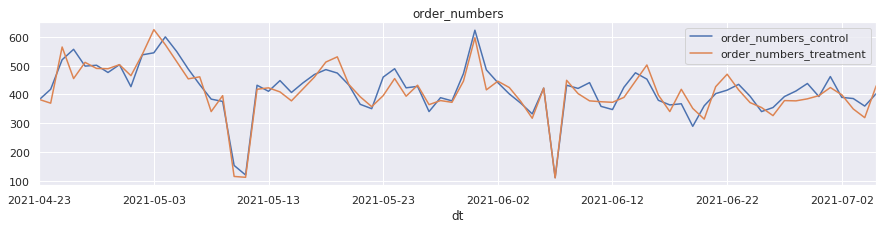

<Figure size 432x288 with 0 Axes>

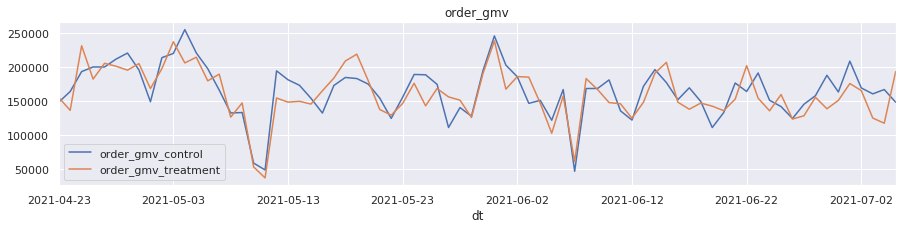

<Figure size 432x288 with 0 Axes>

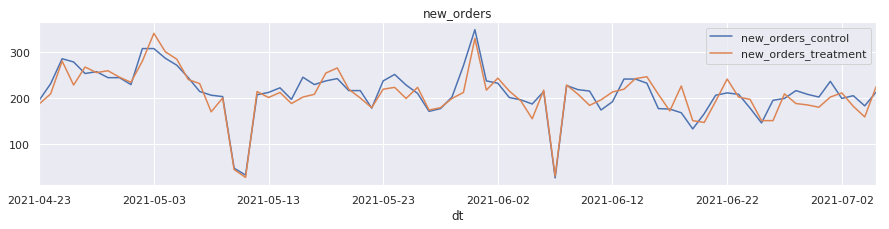

<Figure size 432x288 with 0 Axes>

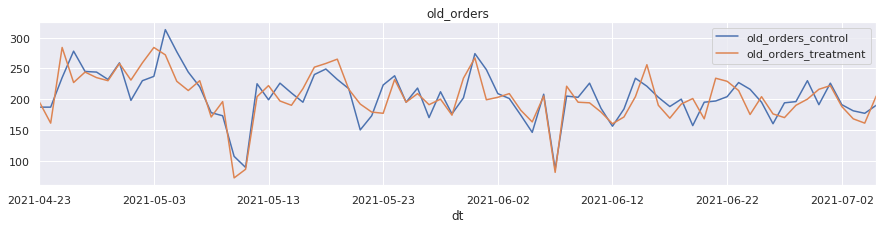

<Figure size 432x288 with 0 Axes>

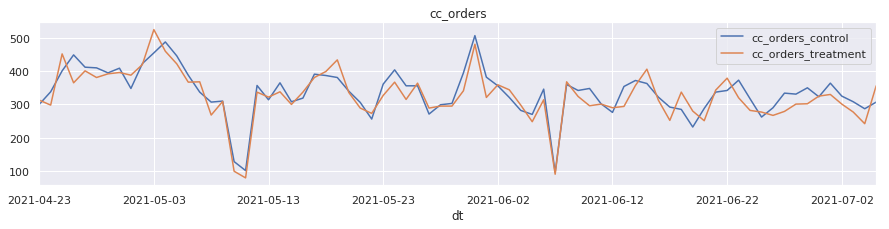

<Figure size 432x288 with 0 Axes>

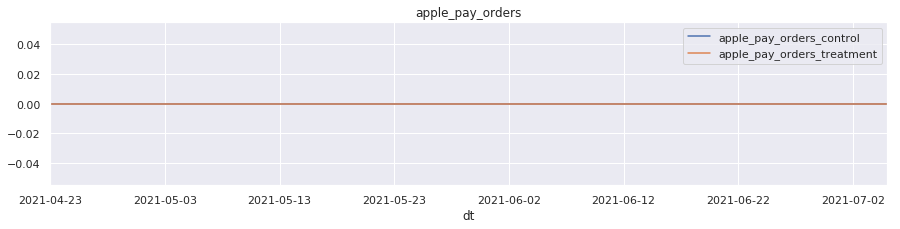

<Figure size 432x288 with 0 Axes>

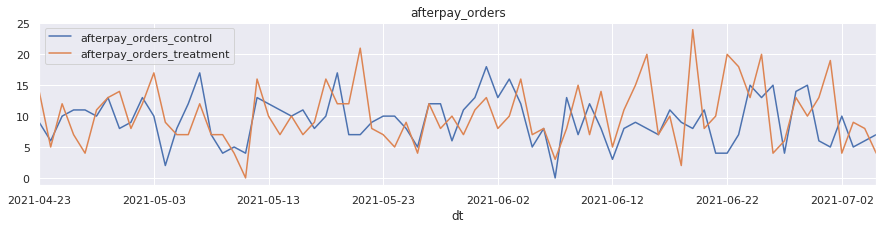

<Figure size 432x288 with 0 Axes>

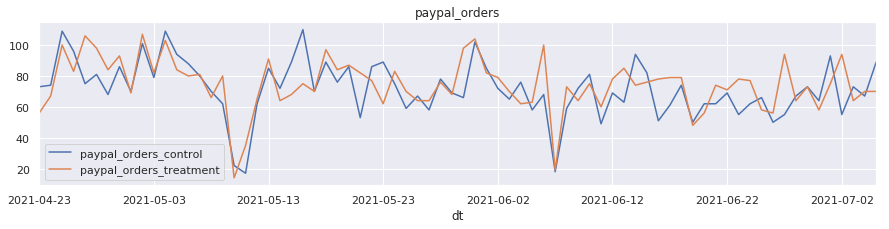

<Figure size 432x288 with 0 Axes>

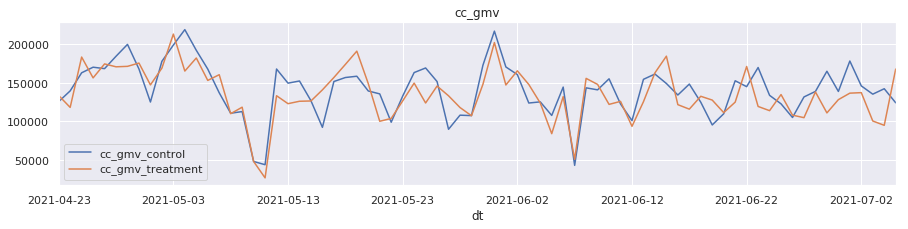

<Figure size 432x288 with 0 Axes>

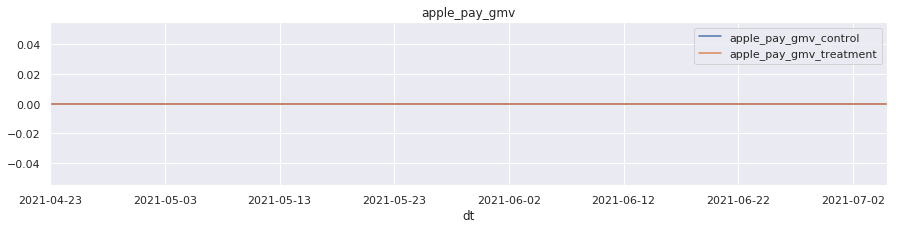

<Figure size 432x288 with 0 Axes>

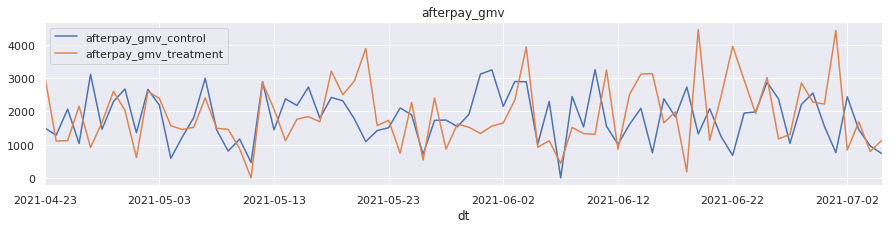

<Figure size 432x288 with 0 Axes>

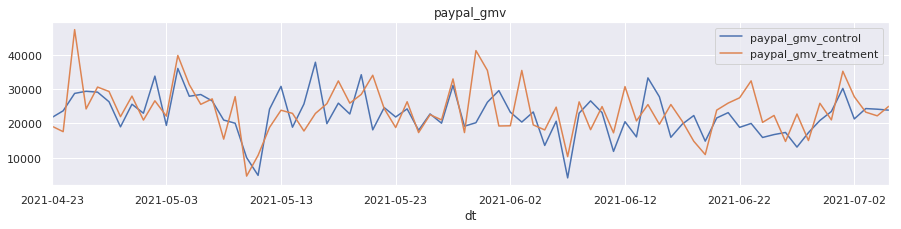

<Figure size 432x288 with 0 Axes>

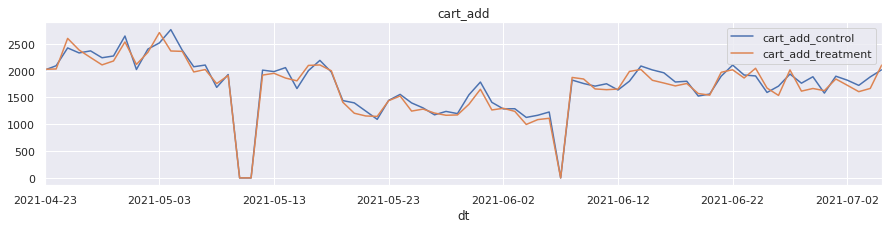

<Figure size 432x288 with 0 Axes>

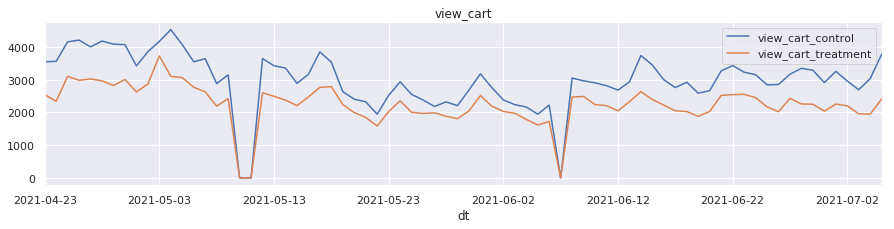

<Figure size 432x288 with 0 Axes>

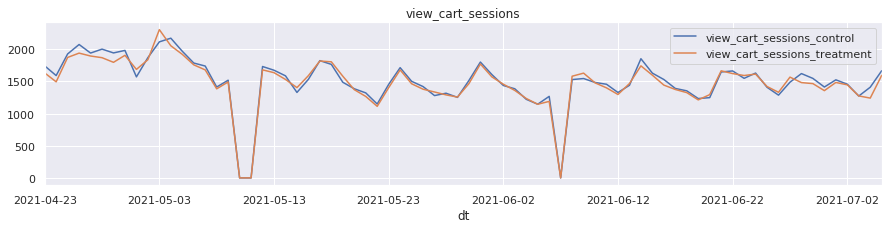

<Figure size 432x288 with 0 Axes>

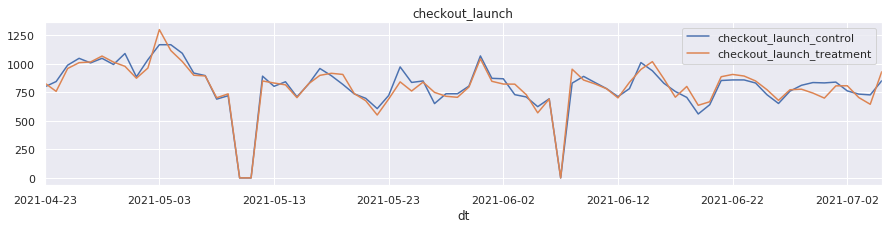

<Figure size 432x288 with 0 Axes>

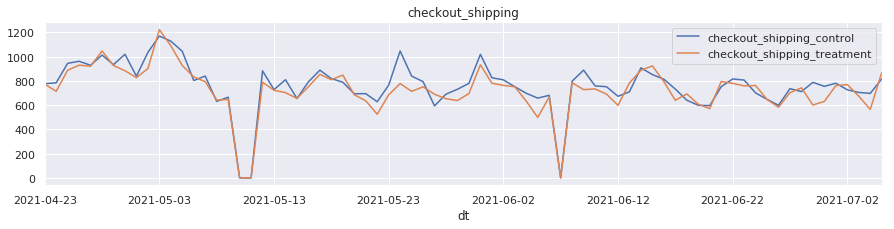

<Figure size 432x288 with 0 Axes>

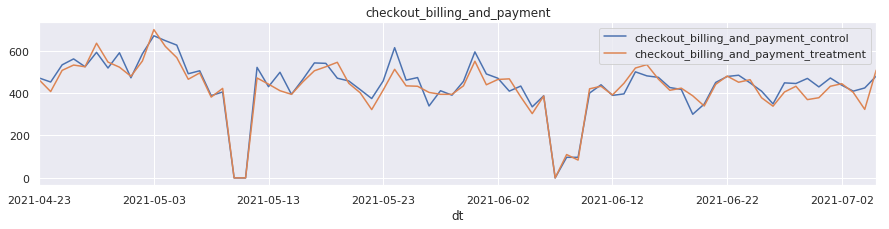

<Figure size 432x288 with 0 Axes>

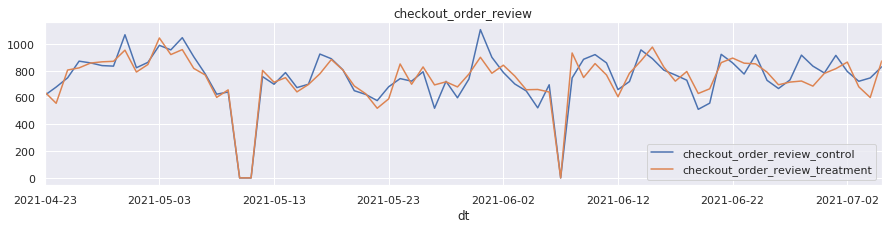

<Figure size 432x288 with 0 Axes>

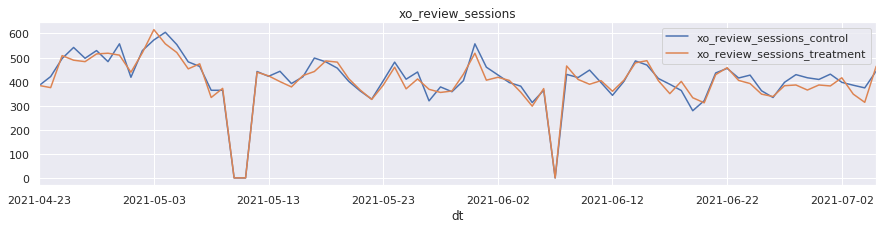

<Figure size 432x288 with 0 Axes>

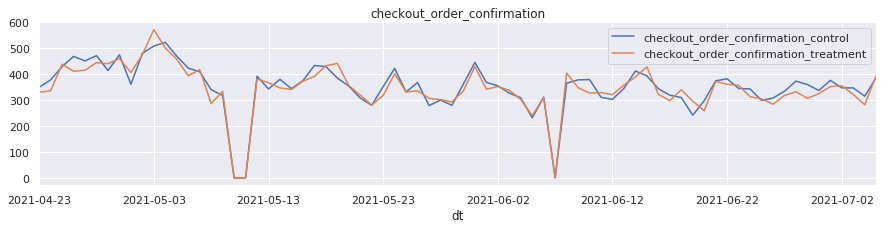

In [34]:
day_by_day(df_dt, col_list, control, treatment)

## % Visitors

In [35]:
df1.head(1)

,dt,visitor_id,test_variant,first_trigger_dt,order_numbers,order_gmv,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,cart_add,view_cart,view_cart_sessions,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,xo_review_sessions,checkout_order_confirmation
0,2021-06-16,c56aa5c5-161b-43e5-a5da-887d994969a9,treatment,2021-05-12,0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0


In [36]:
col_list = df1.columns.values[5:]
cnt_q = '\n'.join(['        ,MAX(IF({elem} > 0, 1, 0)) as visitors_{elem}'.format(elem=elem) for elem in col_list])
sum_q = '\n'.join(['        ,SUM(visitors_{elem}) as visitors_{elem}'.format(elem=elem) for elem in col_list])

q = """
    SELECT test_variant
        , COUNT(visitor_id) as visitors
    {sum_q}
    FROM 
        (SELECT test_variant
            , visitor_id
         {cnt_q}
         FROM {tmp_user_table3}
         where test_variant in ('{treatment}', '{control}')
         GROUP BY 1, 2
        ) t
    GROUP BY 1
""".format(tmp_user_table3=tmp_user_table3,sum_q=sum_q, treatment = treatment, control=control
           , cnt_q=cnt_q)

print(q)


    SELECT test_variant
        , COUNT(visitor_id) as visitors
            ,SUM(visitors_order_gmv) as visitors_order_gmv
        ,SUM(visitors_new_orders) as visitors_new_orders
        ,SUM(visitors_old_orders) as visitors_old_orders
        ,SUM(visitors_cc_orders) as visitors_cc_orders
        ,SUM(visitors_apple_pay_orders) as visitors_apple_pay_orders
        ,SUM(visitors_afterpay_orders) as visitors_afterpay_orders
        ,SUM(visitors_paypal_orders) as visitors_paypal_orders
        ,SUM(visitors_cc_gmv) as visitors_cc_gmv
        ,SUM(visitors_apple_pay_gmv) as visitors_apple_pay_gmv
        ,SUM(visitors_afterpay_gmv) as visitors_afterpay_gmv
        ,SUM(visitors_paypal_gmv) as visitors_paypal_gmv
        ,SUM(visitors_cart_add) as visitors_cart_add
        ,SUM(visitors_view_cart) as visitors_view_cart
        ,SUM(visitors_view_cart_sessions) as visitors_view_cart_sessions
        ,SUM(visitors_checkout_launch) as visitors_checkout_launch
        ,SUM(visitors_checkout

In [11]:
q = """

    SELECT test_variant
        , COUNT(visitor_id) as visitors
            ,SUM(visitors_order_gmv) as visitors_order_gmv
        ,SUM(visitors_new_orders) as visitors_new_orders
        ,SUM(visitors_old_orders) as visitors_old_orders
        ,SUM(visitors_cc_orders) as visitors_cc_orders
        ,SUM(visitors_apple_pay_orders) as visitors_apple_pay_orders
        ,SUM(visitors_afterpay_orders) as visitors_afterpay_orders
        ,SUM(visitors_paypal_orders) as visitors_paypal_orders
        ,SUM(visitors_cc_gmv) as visitors_cc_gmv
        ,SUM(visitors_apple_pay_gmv) as visitors_apple_pay_gmv
        ,SUM(visitors_afterpay_gmv) as visitors_afterpay_gmv
        ,SUM(visitors_paypal_gmv) as visitors_paypal_gmv
        ,SUM(visitors_cart_add) as visitors_cart_add
        ,SUM(visitors_view_cart) as visitors_view_cart
        ,SUM(visitors_view_cart_sessions) as visitors_view_cart_sessions
        ,SUM(visitors_checkout_launch) as visitors_checkout_launch
        ,SUM(visitors_checkout_shipping) as visitors_checkout_shipping
        ,SUM(visitors_checkout_billing_and_payment) as visitors_checkout_billing_and_payment
        ,SUM(visitors_checkout_order_review) as visitors_checkout_order_review
        ,SUM(visitors_xo_review_sessions) as visitors_xo_review_sessions
        ,SUM(visitors_checkout_order_confirmation) as visitors_checkout_order_confirmation
    FROM 
        (SELECT test_variant
            , visitor_id
                 ,MAX(IF(order_gmv > 0, 1, 0)) as visitors_order_gmv
        ,MAX(IF(new_orders > 0, 1, 0)) as visitors_new_orders
        ,MAX(IF(old_orders > 0, 1, 0)) as visitors_old_orders
        ,MAX(IF(cc_orders > 0, 1, 0)) as visitors_cc_orders
        ,MAX(IF(apple_pay_orders > 0, 1, 0)) as visitors_apple_pay_orders
        ,MAX(IF(afterpay_orders > 0, 1, 0)) as visitors_afterpay_orders
        ,MAX(IF(paypal_orders > 0, 1, 0)) as visitors_paypal_orders
        ,MAX(IF(cc_gmv > 0, 1, 0)) as visitors_cc_gmv
        ,MAX(IF(apple_pay_gmv > 0, 1, 0)) as visitors_apple_pay_gmv
        ,MAX(IF(afterpay_gmv > 0, 1, 0)) as visitors_afterpay_gmv
        ,MAX(IF(paypal_gmv > 0, 1, 0)) as visitors_paypal_gmv
        ,MAX(IF(cart_add > 0, 1, 0)) as visitors_cart_add
        ,MAX(IF(view_cart > 0, 1, 0)) as visitors_view_cart
        ,MAX(IF(view_cart_sessions > 0, 1, 0)) as visitors_view_cart_sessions
        ,MAX(IF(checkout_launch > 0, 1, 0)) as visitors_checkout_launch
        ,MAX(IF(checkout_shipping > 0, 1, 0)) as visitors_checkout_shipping
        ,MAX(IF(checkout_billing_and_payment > 0, 1, 0)) as visitors_checkout_billing_and_payment
        ,MAX(IF(checkout_order_review > 0, 1, 0)) as visitors_checkout_order_review
        ,MAX(IF(xo_review_sessions > 0, 1, 0)) as visitors_xo_review_sessions
        ,MAX(IF(checkout_order_confirmation > 0, 1, 0)) as visitors_checkout_order_confirmation
         FROM shahidhya.mp_view_cart_jukwaa_migration_dweb
         where test_variant in ('treatment', 'control')
         GROUP BY 1, 2
        ) t
    GROUP BY 1
"""

In [12]:
df_visitors = pd.read_sql_query(q, conn)

In [13]:
df_visitors.head()

,test_variant,visitors,visitors_order_gmv,visitors_new_orders,visitors_old_orders,visitors_cc_orders,visitors_apple_pay_orders,visitors_afterpay_orders,visitors_paypal_orders,visitors_cc_gmv,visitors_apple_pay_gmv,visitors_afterpay_gmv,visitors_paypal_gmv,visitors_cart_add,visitors_view_cart,visitors_view_cart_sessions,visitors_checkout_launch,visitors_checkout_shipping,visitors_checkout_billing_and_payment,visitors_checkout_order_review,visitors_xo_review_sessions,visitors_checkout_order_confirmation
0,control,67919,22261,13365,9879,17842,0,485,4057,17842,0,485,4057,49057,65974,65974,32843,28140,22482,24959,24959,22343
1,treatment,66912,21955,13137,9851,17412,0,528,4147,17412,0,528,4147,47781,65458,65458,32479,27376,21868,24484,24484,21885


In [38]:
calculate_prop(df_visitors, df_visitors.columns.values[2:], control, treatment).reset_index()\
    .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

/opt/cloudera/parcels/Anaconda/envs/py2_kernel/lib/python2.7/site-packages/statsmodels/stats/weightstats.py:671: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


,Metric,Treatment Size,Treatment Total,Treatment Mean,Control Size,Control Total,Control Mean,Lift,Lift_%,P-value
0,visitors_order_gmv,66912,21955,0.3281,67919,22261,0.3278,0.00036,0.11%,0.8882
1,visitors_new_orders,66912,13137,0.1963,67919,13365,0.1968,-0.00045,-0.23%,0.8367
2,visitors_old_orders,66912,9851,0.1472,67919,9879,0.1455,0.00177,1.22%,0.3577
3,visitors_cc_orders,66912,17412,0.2602,67919,17842,0.2627,-0.00247,-0.94%,0.3015
4,visitors_apple_pay_orders,66912,0,0.0000,67919,0,0.0000,0.00000,0.00%,nan
5,visitors_afterpay_orders,66912,528,0.0079,67919,485,0.0071,0.00075,10.50%,0.1108
6,visitors_paypal_orders,66912,4147,0.0620,67919,4057,0.0597,0.00224,3.76%,0.0848
7,visitors_cc_gmv,66912,17412,0.2602,67919,17842,0.2627,-0.00247,-0.94%,0.3015
8,visitors_apple_pay_gmv,66912,0,0.0000,67919,0,0.0000,0.00000,0.00%,nan
9,visitors_afterpay_gmv,66912,528,0.0079,67919,485,0.0071,0.00075,10.50%,0.1108


## Compare day by day

In [39]:
q = """
    SELECT test_variant
        , dt
        , COUNT(visitor_id) as visitors
    {sum_q}
    FROM 
        (SELECT test_variant
            , visitor_id
            , dt
         {cnt_q}
         FROM {tmp_user_table3}
         where test_variant in ('{treatment}', '{control}')
         GROUP BY 1, 2, 3
        ) t
    GROUP BY 1, 2
""".format(tmp_user_table3=tmp_user_table3,sum_q=sum_q, treatment = treatment, control=control
           , cnt_q=cnt_q)

df_visitors_dt = pd.read_sql(q,conn)

,dt,test_variant_control,visitors_control,visitors_order_gmv_control,visitors_new_orders_control,visitors_old_orders_control,visitors_cc_orders_control,visitors_apple_pay_orders_control,visitors_afterpay_orders_control,visitors_paypal_orders_control,visitors_cc_gmv_control,visitors_apple_pay_gmv_control,visitors_afterpay_gmv_control,visitors_paypal_gmv_control,visitors_cart_add_control,visitors_view_cart_control,visitors_view_cart_sessions_control,visitors_checkout_launch_control,visitors_checkout_shipping_control,visitors_checkout_billing_and_payment_control,visitors_checkout_order_review_control,visitors_xo_review_sessions_control,visitors_checkout_order_confirmation_control,test_variant_treatment,visitors_treatment,visitors_order_gmv_treatment,visitors_new_orders_treatment,visitors_old_orders_treatment,visitors_cc_orders_treatment,visitors_apple_pay_orders_treatment,visitors_afterpay_orders_treatment,visitors_paypal_orders_treatment,visitors_cc_gmv_treatment,visitors_apple_pay_gmv_treatment,visitors_afterpay_gmv_treatment,visitors_paypal_gmv_treatment,visitors_cart_add_treatment,visitors_view_cart_treatment,visitors_view_cart_sessions_treatment,visitors_checkout_launch_treatment,visitors_checkout_shipping_treatment,visitors_checkout_billing_and_payment_treatment,visitors_checkout_order_review_treatment,visitors_xo_review_sessions_treatment,visitors_checkout_order_confirmation_treatment
0,2021-04-28,control,67919,410,223,189,334,0,9,68,334,0,9,68,1078,1686,1686,671,556,446,490,490,437,treatment,66912,400,226,179,313,0,8,79,313,0,8,79,1020,1597,1597,644,546,446,478,478,418
1,2021-06-06,control,67919,325,194,135,259,0,8,58,259,0,8,58,790,1136,1136,452,395,289,345,345,298,treatment,66912,317,182,140,242,0,6,71,242,0,6,71,739,1076,1076,455,391,303,346,346,286
2,2021-05-20,control,67919,344,187,164,266,0,7,71,266,0,7,71,867,1229,1229,501,407,332,380,380,329,treatment,66912,353,196,162,275,0,9,69,275,0,9,69,797,1234,1234,517,408,336,390,390,341
3,2021-06-11,control,67919,285,153,136,237,0,7,41,237,0,7,41,842,1240,1240,469,371,303,354,354,293,treatment,66912,305,170,140,247,0,11,48,247,0,11,48,797,1195,1195,489,392,307,368,368,310
4,2021-06-16,control,67919,305,157,150,258,0,7,41,258,0,7,41,935,1320,1320,542,431,330,383,383,323,treatment,66912,314,178,140,250,0,7,58,250,0,7,58,893,1255,1255,533,429,331,374,374,309


/opt/cloudera/parcels/Anaconda-5.3.1/envs/py2_kernel/lib/python2.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


<Figure size 432x288 with 0 Axes>

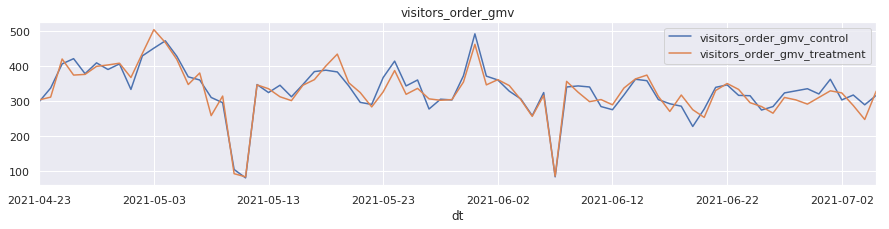

<Figure size 432x288 with 0 Axes>

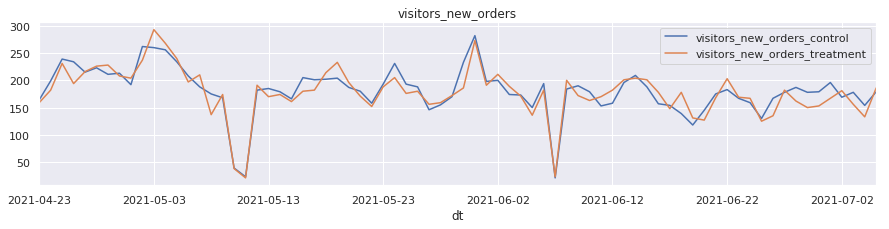

<Figure size 432x288 with 0 Axes>

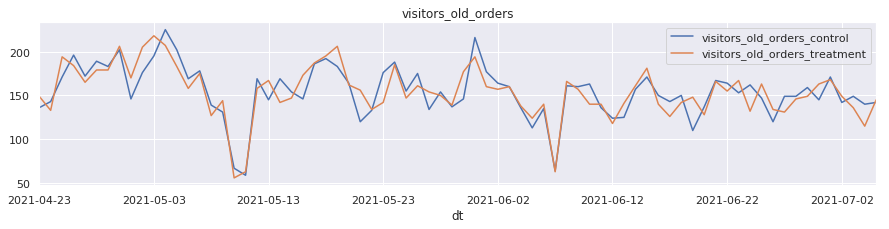

<Figure size 432x288 with 0 Axes>

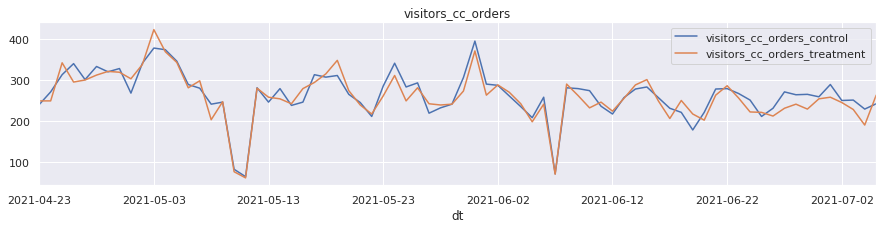

<Figure size 432x288 with 0 Axes>

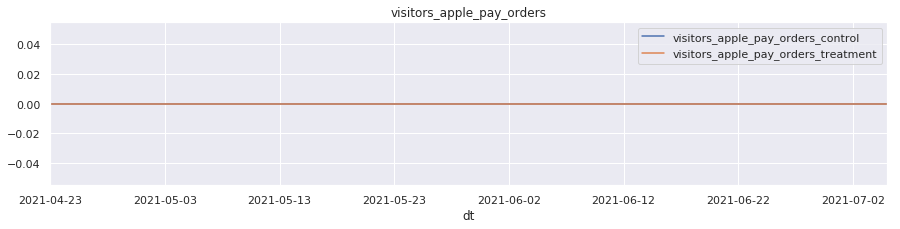

<Figure size 432x288 with 0 Axes>

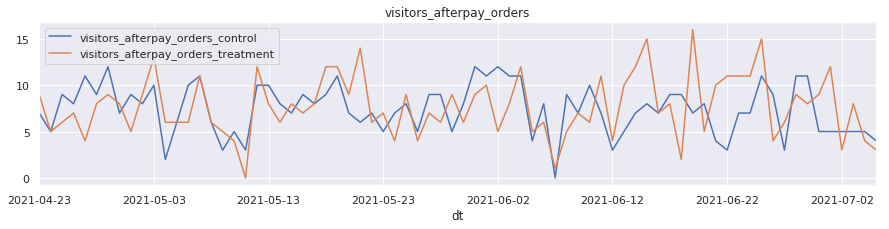

<Figure size 432x288 with 0 Axes>

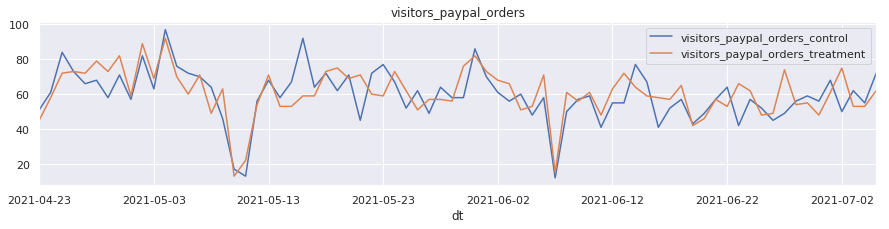

<Figure size 432x288 with 0 Axes>

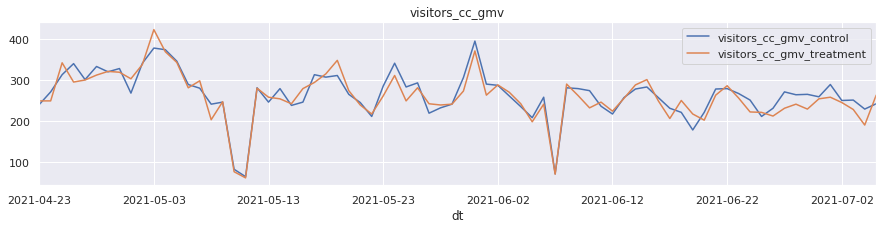

<Figure size 432x288 with 0 Axes>

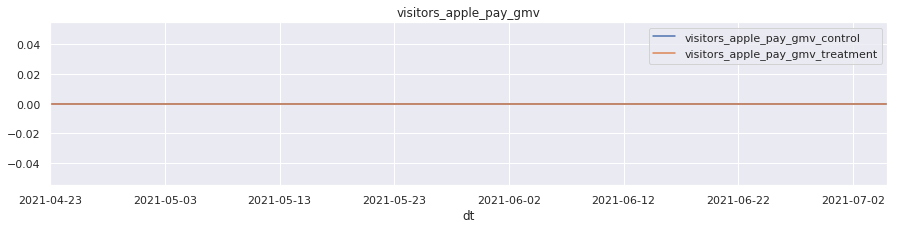

<Figure size 432x288 with 0 Axes>

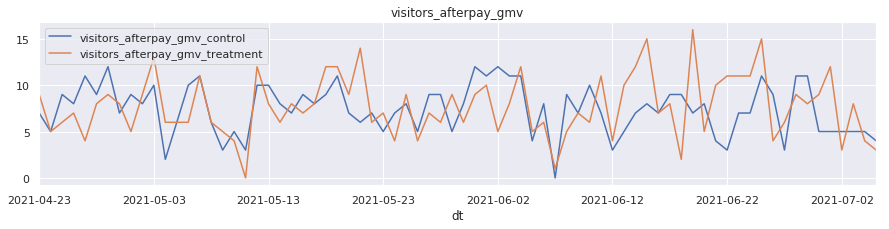

<Figure size 432x288 with 0 Axes>

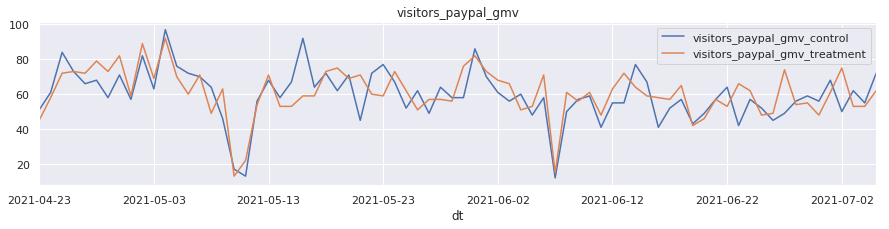

<Figure size 432x288 with 0 Axes>

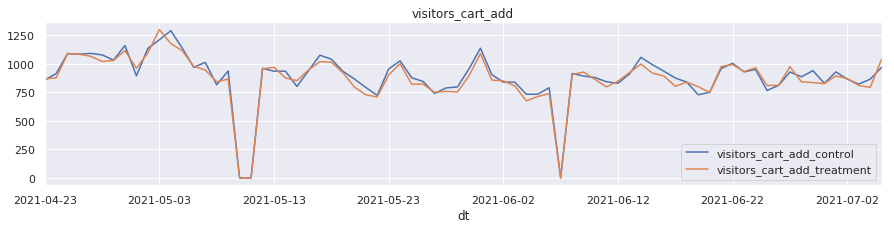

<Figure size 432x288 with 0 Axes>

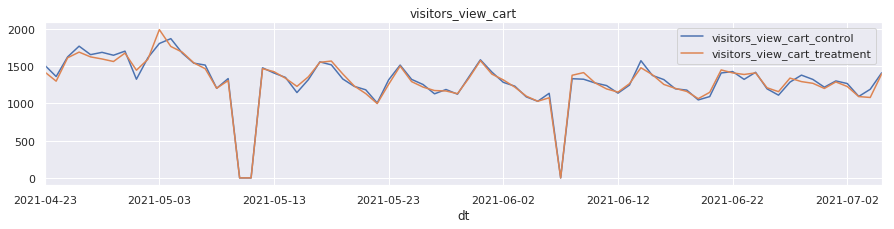

<Figure size 432x288 with 0 Axes>

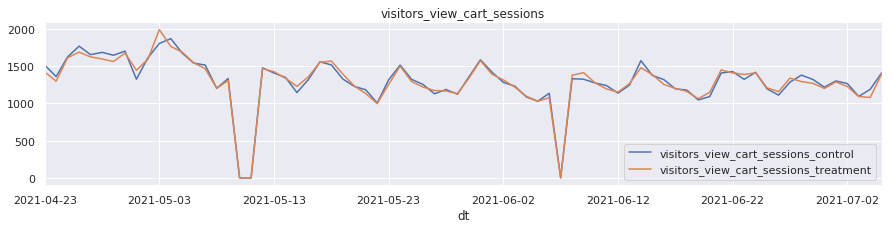

<Figure size 432x288 with 0 Axes>

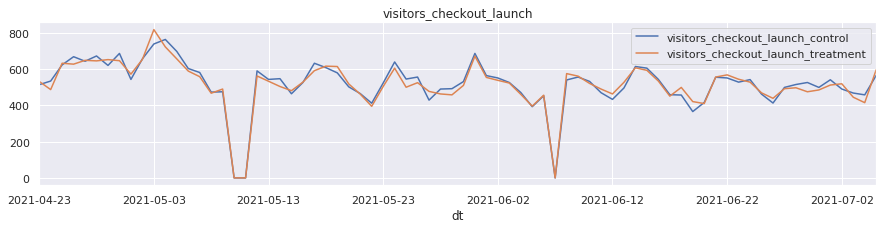

<Figure size 432x288 with 0 Axes>

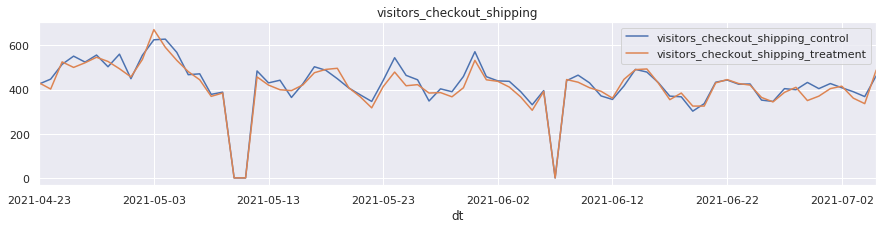

<Figure size 432x288 with 0 Axes>

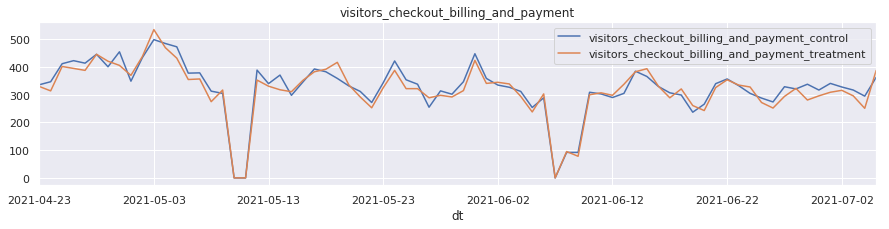

<Figure size 432x288 with 0 Axes>

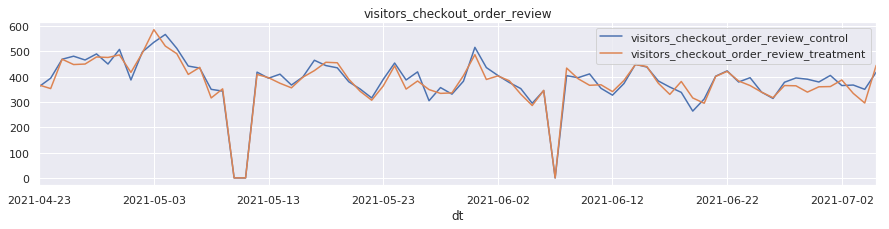

<Figure size 432x288 with 0 Axes>

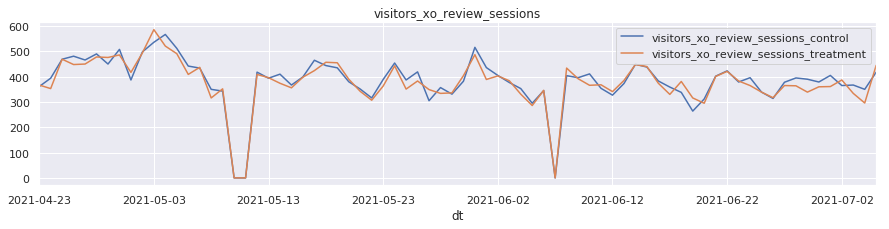

<Figure size 432x288 with 0 Axes>

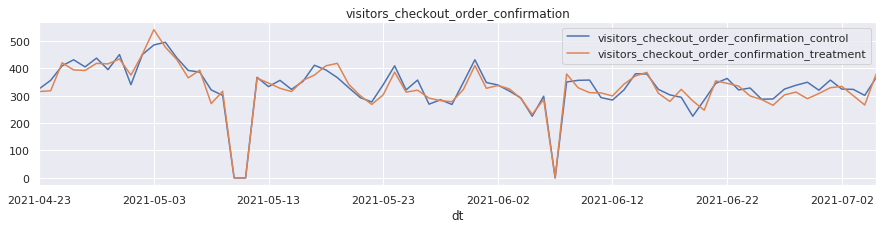

In [40]:
day_by_day(df_visitors_dt, df_visitors_dt.columns.values[3:], control, treatment)